In [44]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pickle
#import os
#import re

In [45]:
def poisson_process(n, lbd, alpha):
    """
    Creates rainfall series based on Poisson process.

    Parameters
    ----------
    n: array_like
       The number of events
    lbd: array_like 
       The rain events mean distribution 
    alpha: array_like
       Mean rain depth

    Returns
    -------
    samples: ndarray
       n Rain events in the same unit of alpha.
    """
    rain = np.zeros(n)
    for i in np.arange(n):
        n1 = np.random.uniform(0, 1, 1)
        if n1 < lbd:
            n2 = np.random.uniform(0, 1, 1)
            rain[i] = -alpha * np.log((1 - n2))
        else:
            rain[i] = 0
    return rain

def evaporation_loss(s, sh, c, evmax):
    """
    Computes evaporation in m/day 
    Args:
        s:                               soil moisture
        sstar: soil moisture where ET decreases with s
        sh:                          hygroscopic point
        emax:          maximum evapotranspiration rate
    """
    if 0 <= s <= sh:
        ev = 0
    elif sh< s< sstar:
        ev = evmax*(1-c)*((s-sh)/(sstar-sh))
    else:
        ev = evmax*(1-c)
    return ev

def transpiration_loss(s, sw, sstar, c, trmax):
    """
    Computes transpiration in m/day
    Args:
        s: soil moisture
        sstar: soil moisture where T decreases with s
        sw: wilting point 
        emax: maximum evapotranspiration rate
    """
    if s<=sw:
        tr = 0
    elif sw < s <= sstar:
        tr = trmax * c * ((s-sw)/(sstar-sw))
    else:
        tr = trmax * c
    return tr

def leakage_loss(s):
    if s>1:
        s=1
    return ks * s**13

def canopy(rain, rstar, c):
    """
    Returns the amount of water intercepted by the vegetation canopy
    """
    if rain <= rstar:
        return rain * c
    else:
        return rstar * c


def hr_moisture_function(sg):
    return (c4*sg**(p*ns)*(sg-1)**ng)/((c2*sg**(p*ns) + kdoc) * (c3 * (sg-1)**ng + ko2))


def swb_f_inter_targ(sd, stil, scap, rain, cd):
    
    # Heterotrophic respiration as a function of soil moisture availability
    rd  = hr_moisture_function(sd)
    
    # Add throughfall to soil moisture
    ci =  canopy(rain, rstar, cd) 
    sd  = sd + (rain-ci)/(n * zr)

    # Losses beyond field capacity
    if sd > sfc:
        sd = sd - leakage_loss(sd)*(dt/(n * zr))

    # Transpiration and evaporation loss   
    Td =     transpiration_loss(sd, sw, sstar, cd, trmax) # m/d
    Ed =              evaporation_loss(sd, sh, cd, evmax) # m/d
       
    # Irrigation input
    Id = 0
    if sd - (Td + Ed)*(dt/(n * zr)) < stil:
        Id = n*zr*(scap - (sd - (Td+Ed)*(dt/(n * zr))))  # in meters
        sd = scap
    else:     
        sd = sd - (Td + Ed)*(dt/(n * zr))
    
    output = {'sd': sd, 'ci':ci, 'rd' : rd, 'Transinter': Td, 'Lossd': Td+Ed, 'Id': Id}
    return output


def cover_dynamics(cg, bg, t, Tg):
    
    # Canopy cover
    if t <= tsen:
        cg = cg + (rgnc * Tg - rm * cg**2) * dt
        
    else:
        cg = cg + (rgnc * Tg - (rm + gamma * (t-tsen)) * cg**2) * dt
    
    # Biomass
    bg = bg + W * (Tg/ET0) * dt
            
    output = {'cg': cg, 'bg': bg} # kg of B/m2
    return output

In [81]:


# Soil (and loss) properties
n      =        0.43 # [-]
zr     =         1.0 # meter
sh     =        0.14 # [-]
sw     =        0.17 # [-]
sstar  =        0.35 # [-]
sfc    =        0.59 # [-] 
ET0    =       0.005 # [m/d]
evmax  =    1.10*ET0 # [m/d] (Kce*ET0= 5*10^-3m/d * 1.03)
trmax  =    1.03*ET0 # [m/d] (Kcb*Et0= 5*10^-3m/d * 1.1)
rgnc   = 560 * 0.054 # [1/m] rg times nc
ks     =        0.33 # m/d

#Canopy/Biomass Properties
rm    =  0.200          # 1/d       Pelak
gamma =  0.005          # 1/d2      Pelak
tsen  =    110          # d         Pelak 
W     = 0.0337          # kg B/m2/d Pelak
HI    =  0.500          # kg Y/kg B Pelak
rstar =  0.002          # m/d Assumed

# Microbes Respiration Properties
mg   =              1.5;
ng   =                2;
p    =            0.794;
ms   =              1.5;
ns   =                2;
c1   =     0.5*(1-0.39); # Umax*(1-CUE)
c2   =      1*n**(p*ms); # DOCb*(phi)^(p*ms)
c3   =        1*n**(mg); # Ob*(Ob^mg)
kdoc =             0.05;
c4   =         c1*c2*c3;
ko2  =            0.005;

# Irrigation Strategy: intervention and target soil moisture
s_int =                        0.25
s_tar =                        0.55

# Get all local variables and their values
variables = locals()

# Save the variable names and values to a dictionary
variables_dict = {name: value for name, value in variables.items()}

In [82]:
# Rainfall Properties
dt     =                        1/48
lbd_v  =                   0.18 * dt
aph_v  =                      0.0096 # m
times  =                          1
nr     =             140 * int(1/dt)

# Simulating a growing season rainfall time series (number of times)
rain  = np.zeros(nr*times)

for j in range (0,times):
    # Run the model for a time series of rain
    nd   =                  140 * int(1/dt)
    rain[j*nr:j*nr+nr] = poisson_process(nd, lbd_v, aph_v)

In [83]:
# Create objects to receive the results
s_out  = np.zeros(nr*times)
ci_out = np.zeros(nr*times)
r_out  = np.zeros(nr*times)
b_out  = np.zeros(nr*times)
c_out  = np.zeros(nr*times)
I_out  = np.zeros(nr*times)
L_out  = np.zeros(nr*times)
T_out  = np.zeros(nr*times)

# A loop for a growing season
for j in range (0, times):    
    # Initial conditions
    s0 =   sstar
    c0 =    0.01
    b0 =     0.0

    for i in range(j*nr, j*nr+nr):
        s_dict = swb_f_inter_targ(s0, s_int, s_tar, rain[i], c0)
        c_dict = cover_dynamics(c0, b0, (i-j*nr)*dt, s_dict['Transinter'])

        s_out[i]  =         s_dict['sd']
        r_out[i]  =         s_dict['rd'] 
        ci_out[i] =         s_dict['ci'] 
        I_out[i]  =         s_dict['Id']
        L_out[i]  =      s_dict['Lossd']
        T_out[i]  = s_dict['Transinter']
        
        b_out[i]  = c_dict['bg'] 
        c_out[i]  = c_dict['cg']

        s0        = s_dict['sd']
        c0        = c_dict['cg']
        b0        = c_dict['bg']  

In [84]:
# Convert the results to daily timescale
days = np.repeat(np.arange(nr * dt*times), int(1/dt)) + 1

swb_res = pd.DataFrame({'Days': days, 'Rain': rain, \
                           's': s_out, 'r': r_out, 'b':  b_out, 'c' : c_out, 'I': I_out})

# Compute daily values
swb_daily = swb_res.pivot_table(values=['Rain', 's', 'r', 'b', 'c', 'I'],
                                index='Days',
                                aggfunc={'Rain': np.sum,
                                         's': 'last', 'r': 'last', 'b': 'last', 'c': 'last', 'I': np.sum})

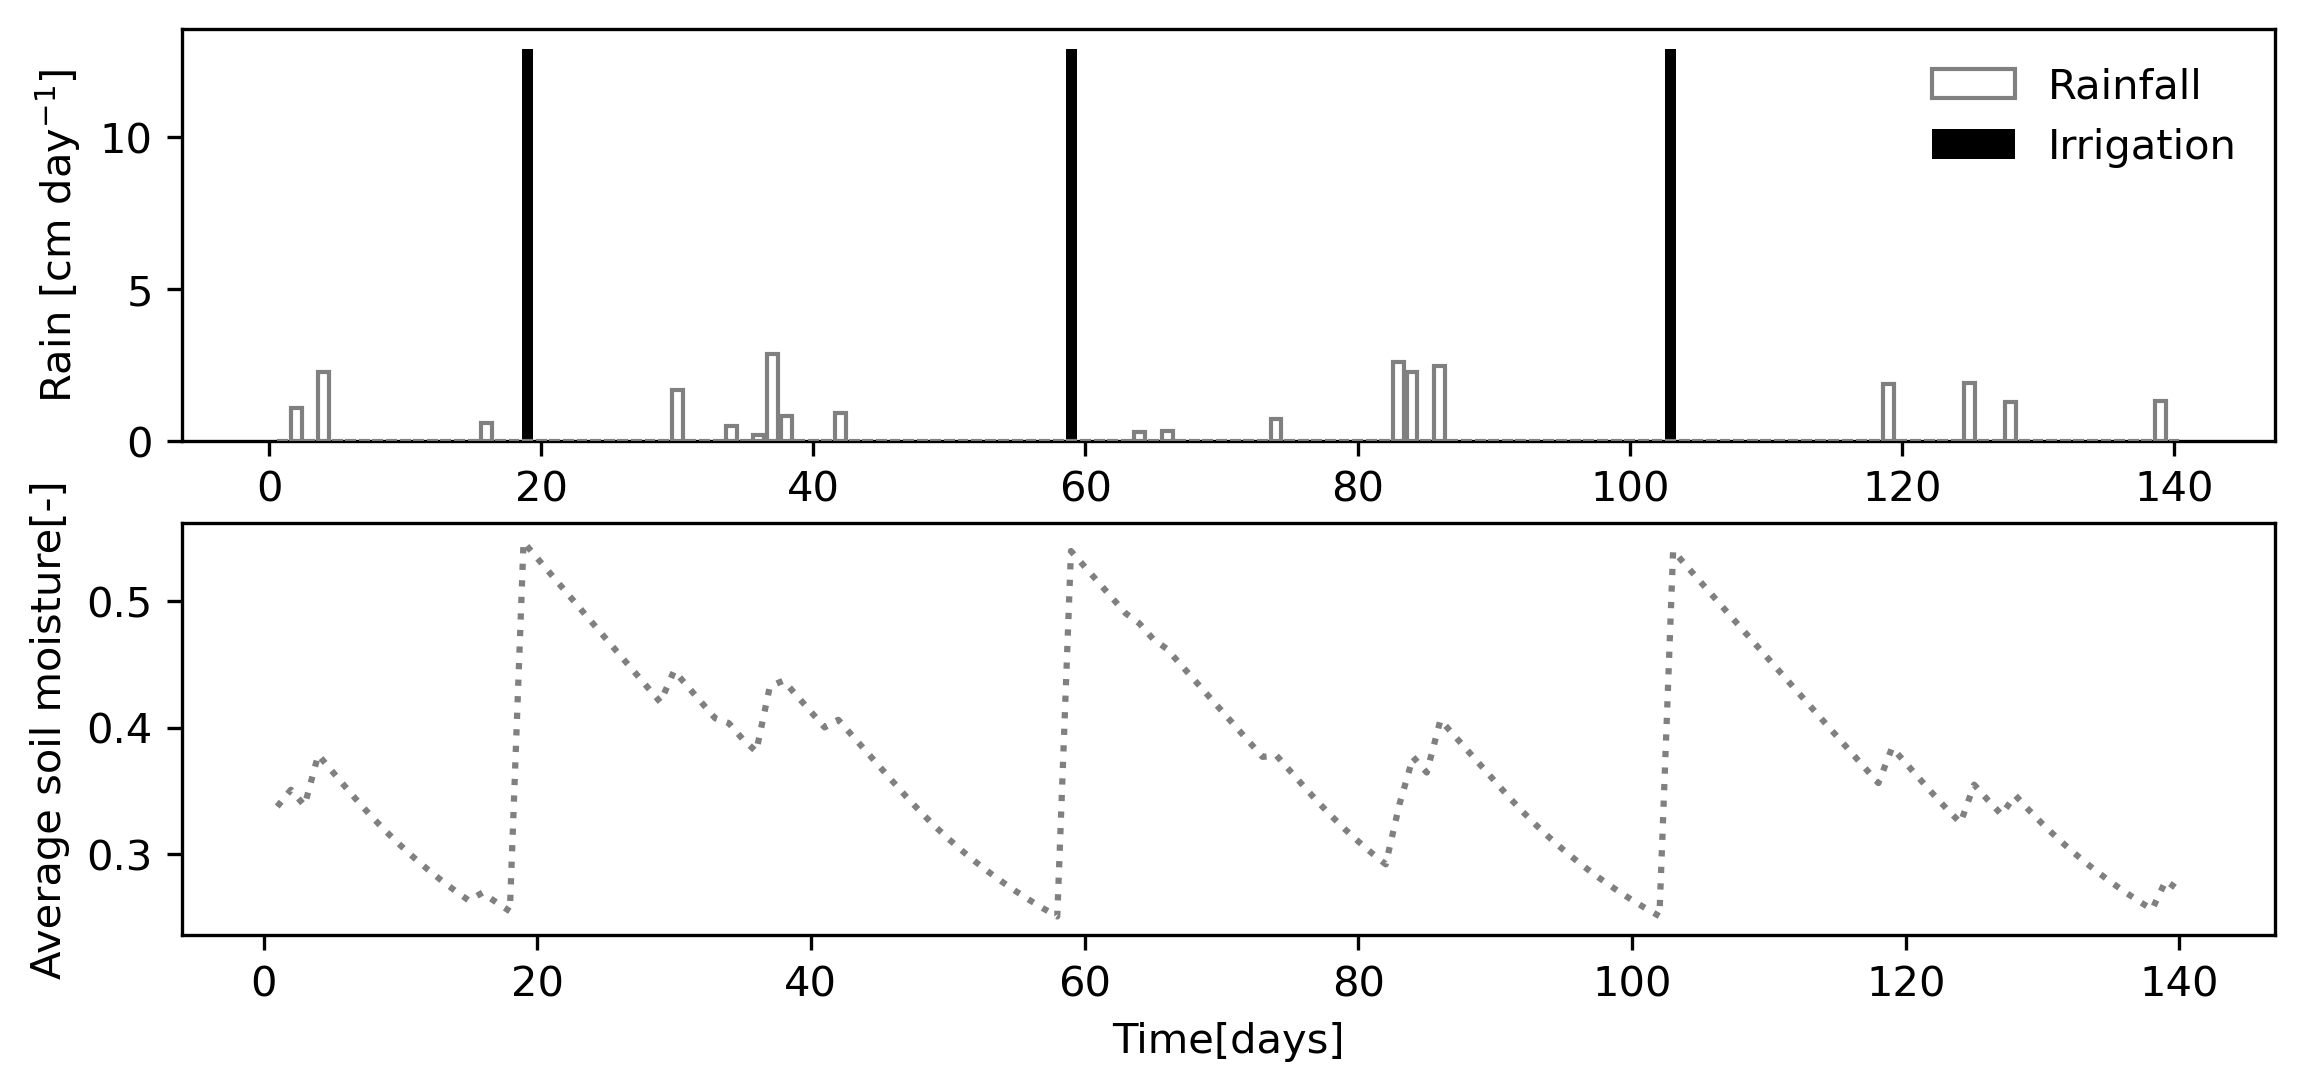

In [86]:
k     =                 0
start =       int(k*nr*dt)
end   = int(k*nr*dt+nr*dt)

starti =       int(k*nr*dt)
endi   = int(k*nr*dt+nr*dt)

if start!=0:
    start=start+1


xl = [0, int(len(swb_daily))//times]
fig = plt.figure(figsize=(9, 4), dpi = 300)

# Rain and canopy interception
ax1 = fig.add_subplot(211)
ax1.bar(swb_daily.index[starti:endi],     100*swb_daily.Rain[start:end], edgecolor = 'grey', label = 'Rainfall', fill=False, linewidth=1, zorder=20)
ax1.bar(swb_daily.index[starti:endi],     100*swb_daily.I[start:end], color =   'black', label = 'Irrigation')
ax1.set_ylabel('Rain [cm day$^{-1}$]')
plt.legend(frameon = False)
#ax1.set_ylim([-1, 7])

# Rain and canopy interception
# Soil moisture
ax2 = fig.add_subplot(212)
ax2.plot(swb_daily.index[starti:endi], swb_daily.s[start:end],  'grey', linestyle = 'dotted', label =   'avo', zorder = 4)
ax2.set_ylabel('Average soil moisture[-]')
ax2.set_xlabel('Time[days]')


# Respiration
ax3 = fig.add_subplot(413)
ax3.plot(df.index[starti:endi],   df.Tavo[start:end],  linestyle = 'dotted', color =  'red', label =   'avo',zorder =4)
plt.legend(frameon = False)
#ax3.set_xlim(xl)
#ax3.set_ylim([0, 1])
ax3.set_ylabel(' Rate')


# Crop Biomass
ax4 = fig.add_subplot(414)
ax4.plot(df.index[starti:endi],  df.bavo[start:end], linestyle =  'dotted', color =       'red', label =  'avo', zorder = 4)

#ax4.set_xlim(xl)
#ax4.set_ylim([0, 1.7])
plt.legend(frameon = False)
ax4.set_ylabel('Crop Yield [kg m$^{-2}$]')



plt.show()